<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')

Running on cpu


In [3]:
batch_size = 64

train_data = torchvision.datasets.MNIST('./data', train =True, download = True, transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, shuffle =True, batch_size = batch_size)

In [4]:
dataiter = iter(train_loader)
imgs, labels = next(dataiter)

In [5]:
def imshow(imgs):
  imgs = make_grid(imgs)
  npimgs = imgs.numpy()
  disp = np.transpose(npimgs, (1,2,0))
  
  plt.figure(figsize=(8,8))
  plt.imshow(disp, cmap = 'Greys_r')
  plt.axis("off")
  plt.title('Training Images')
  plt.show()

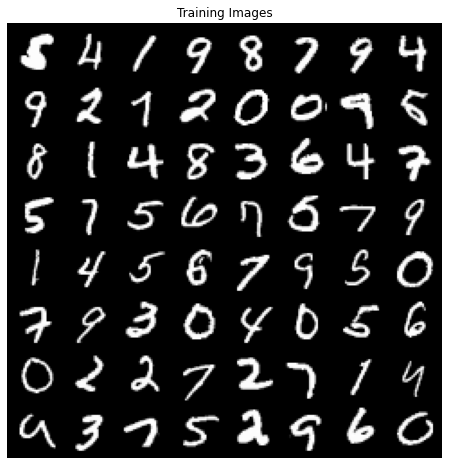

In [6]:
imshow(imgs)

In [7]:
# Generator Hyperparameters
image_size = 28 # (28 x 28)

input_size = 100
feature_map_size = 28
out_channels = 1
real_size = imgs.view(imgs.size(0), -1).size(1)

In [8]:
class Generator(nn.Module): 
  def __init__(self, input_size, feature_map_size, out_channels):
    super().__init__()

    self.generate = nn.Sequential(
        nn.ConvTranspose2d(in_channels= input_size, 
                           out_channels = feature_map_size*8,
                           kernel_size = 4,
                           stride = 1,
                           padding = 0,
                           bias = False),  # Bias = False, since we use Batch Normalization
        nn.BatchNorm2d(feature_map_size*8),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*8, 
                           out_channels = feature_map_size*4,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False), 
        nn.BatchNorm2d(feature_map_size*4),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*4, 
                           out_channels = feature_map_size*2,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False), 
        nn.BatchNorm2d(feature_map_size*2),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size*2, 
                           out_channels = feature_map_size,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),  
        nn.BatchNorm2d(feature_map_size),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(in_channels= feature_map_size, 
                           out_channels = out_channels,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),  
        nn.Tanh()
    )

  def forward(self, input):
    return self.generate(input)

In [9]:
class Discriminator(nn.Module):
  def __init__(self, input_size, feature_map_size, out_channels):
    super().__init__()

    self.discriminate = nn.Sequential(
        # take the output channel of the generator
        nn.Conv2d(in_channels = out_channels, 
                  out_channels = feature_map_size,
                  kernel_size = 4,
                  stride =2,
                  padding =1, 
                  bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size, 
                  out_channels = feature_map_size*2,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*2),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*2, 
                  out_channels = feature_map_size*4,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*4),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*4, 
                  out_channels = feature_map_size*8,
                  kernel_size = 4,
                  stride = 2,
                  padding =1,
                  bias = False),
        nn.BatchNorm2d(feature_map_size*8),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = feature_map_size*8,
                  out_channels = 1, 
                  stride = 4,
                  kernel_size = 1,
                  padding = 0,
                  bias = False),

        nn.Sigmoid(),
    )
  def forward(self, input):
    return self.discriminate(input)

In [10]:
netD = Discriminator(input_size, feature_map_size, out_channels).to(device)
netG = Generator(input_size, feature_map_size, out_channels).to(device)

In [11]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(image_size, image_size, 1,1, device = device)

real_label = 1
fake_label = 0


lr = 0.001
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, beta2))

In [13]:
# training loop

n_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0 

print("Starting training loop...")
print(f"Running on {device}")

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader, 0):

    # Setup
    real_images = data[0].to(device)
    batch_size = real_images.size(0)
    real_label_vector = torch.full((batch_size, ), real_label, dtype = torch.float, device = device) # Vector filled with 1 length 64
    fake_label_vector = torch.full((batch_size, ), fake_label, dtype = torch.float, device = device) # Vector filled with 0 length 64

    #######################################
    #### Training of the Discriminator ####
    ######################################

    # Forward Propagation of Real Images
    netD.zero_grad()
    real_output = netD(real_images).view(-1) # Flattens the matrix
    
    errD_real = criterion(real_output, real_label_vector)
    errD_real.backward()

    D_x = real_output.mean().item()

    # Forward Propagation of Fake Images
    noise = torch.randn(batch_size, input_size, 1, 1, device=device)
    # Generate Fake Image
    fake_image = netG(noise)
    # Feed the fake image to the discriminator
    fake_output = netD(fake_image).view(-1)

    errD_fake = criterion(fake_output, fake_label_vector)
    errD_fake.backward()

    D_G_z1 = fake_output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()

    #################################
    ### Training of the Generator ###
    #################################

    netG.zero_grad()
 
    # Since we updated D, we will perform another forward propagation to netD

    fake_output = netD(fake_image).view(-1)
    
    errG = criterion(fake_output, real_label_vector) # netG must see fake_image as "real"

    errG.backward()
    
    D_G_z2 = fake_output.mean().item()
    optimizerG.step()

    if i % 50 == 0:

      print(f'\n[{epoch}/{num_epochs}]-[{i}/{len(train_loader)}] Loss_D: {errD.item()}, Loss_G: {errG.item()}')
      print(f'D(G(z)): {D_G_z1}/{D_G_z2}')

    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1



Starting training loop...
Running on cpu


RuntimeError: ignored

In [56]:
for i, (imgs, _) in enumerate(train_loader):
  print(_.shape)
 
  break

torch.Size([64])


In [92]:
print("\nHello")


Hello


In [82]:
a = [0.4120, 0.5545, 0.5961, 0.6598, 0.5006, 0.4252, 0.5233, 0.5679, 0.7105,
        0.4932, 0.6673, 0.5114, 0.5371, 0.5625, 0.6097, 0.7219, 0.5050, 0.5141,
        0.6815, 0.6052, 0.7542, 0.5388, 0.6117, 0.7023, 0.4890, 0.5573, 0.7062,
        0.4799, 0.6305, 0.4461, 0.6400, 0.3636, 0.5890, 0.4947, 0.6591, 0.5185,
        0.6466, 0.5524, 0.6095, 0.6541, 0.7218, 0.4413, 0.6325, 0.6365, 0.4078,
        0.6443, 0.4794, 0.5217, 0.6197, 0.5446, 0.6904, 0.4899, 0.4598, 0.6154,
        0.7043, 0.6901, 0.5290, 0.7013, 0.5071, 0.4767, 0.4808, 0.5488, 0.5823,
        0.7475]
print(len(a))

64
